In [2]:
import pandas as pd
import numpy as np

In [3]:
data1 = pd.read_csv('data/0.16667_data.csv')
data2 = pd.read_csv('data/0.09091_data.csv')
data3 = pd.read_csv('data/0.00990_data.csv')

- 0이 major, 1이 minor

In [4]:
X1 = data1.drop('Class', axis=1)
X2 = data2.drop('Class', axis=1)
X3 = data3.drop('Class', axis=1)

# Make graph
- 이 때 다양한 threshold를 통해서 다양한 graph를 만들어보자. 
    - Ensemble : 7번
    - 0.3~1.0을 균등하게 나눠서 진행
- unweight graph
- graph마다 edge의 수가 얼마인지 check

# Node2vec embedding

- `dimensions` : 8, 32
- `p & q` : 0.5&2, 1&1, 2&0.5
- `walk_length` : 8, 16

# Predict
- 어떤 모델을 쓸까?
    - Malhalanobis
    - PCA
    - LOF

In [5]:
from utils import make_graph, scoring
from node2vec import Node2Vec

In [6]:
from anomaly_prob import anomaly_detection_Malhalanobis
from anomaly_linear import anomaly_detection_PCA
from sklearn.neighbors import LocalOutlierFactor

In [33]:
from imblearn.datasets import fetch_datasets

ecoli = fetch_datasets()["ecoli"]
X, y = ecoli.data, ecoli.target
#oil = fetch_datasets()["oil"]
#X, y = oil.data, oil.target

In [34]:
y = np.where(y==-1, 0, 1)

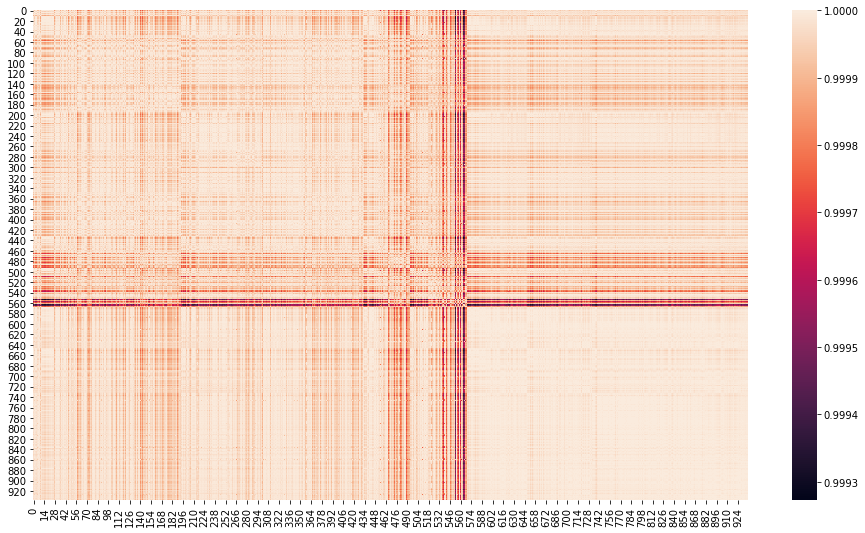

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sim = cosine_similarity(X[:,0:10], X[:,0:10])
plt.figure(figsize=(16,9))
sns.heatmap(sim)
plt.show()

In [59]:
graph = make_graph(X, 0.995)
graph.number_of_edges() / ((len(X)*(len(X)-1)) / 2)

0.025746268656716417

In [44]:
(len(X)*(len(X)-1)) / 2

56280.0

In [60]:
final_anomaly_score_dim8_mal = np.zeros((len(X),))
final_anomaly_score_dim8_pca = np.zeros((len(X),))
final_anomaly_score_dim8_lof = np.zeros((len(X),))
clf = LocalOutlierFactor(n_neighbors=5)
cosine_threshold = [0.98, 0.99, 0.995]

for threshold in cosine_threshold:
    graph = make_graph(X, threshold)
    node2vec = Node2Vec(graph=graph, 
                        dimensions=8,
                        walk_length=8, 
                        p = 0.5, 
                        q = 1.5,
                        weight_key=None, 
                        num_walks=30, 
                        workers=2,
                   )
    node2vec_fit = node2vec.fit(window=3)
    embedding_vec = np.array(node2vec_fit.wv.vectors)
    
    # Malhalanobis
    outlier_score_mal, _ = anomaly_detection_Malhalanobis(embedding_vec)
    outlier_score_mal = (outlier_score_mal - np.mean(outlier_score_mal)) / np.std(outlier_score_mal)
    # PCA
    outlier_score_pca = anomaly_detection_PCA(embedding_vec)
    outlier_score_pca = (outlier_score_pca - np.mean(outlier_score_pca)) / np.std(outlier_score_pca)
    # LOF
    pred_raw = clf.fit_predict(embedding_vec)
    pred_raw = np.where(pred_raw==1, 0, 1)
    
    final_anomaly_score_dim8_mal += outlier_score_mal / len(cosine_threshold)
    final_anomaly_score_dim8_pca += outlier_score_pca / len(cosine_threshold)
    final_anomaly_score_dim8_lof += pred_raw

In [61]:
q1 = np.quantile(final_anomaly_score_dim8_mal, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_mal, 0.75)
IQR = q3 - q1
upper = q3 + 0.5*IQR
result = np.where(final_anomaly_score_dim8_mal < upper, 0, 1)
scoring(y, result)

           Score
Accuracy   0.818
ROC AUC    0.533
Recall     0.171
Precision  0.158
f1 score   0.164

confusion matrix 
          Normal  Abnormal
Normal       269        32
Abnormal      29         6


In [75]:
q1 = np.quantile(final_anomaly_score_dim8_pca, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_pca, 0.75)
IQR = q3 - q1
upper = q3 + 0.7*IQR
result = np.where(final_anomaly_score_dim8_pca < upper, 0, 1)
scoring(y, result)

           Score
Accuracy   0.875
ROC AUC    0.564
Recall     0.171
Precision  0.316
f1 score   0.222

confusion matrix 
          Normal  Abnormal
Normal       288        13
Abnormal      29         6


In [65]:
result = np.where(final_anomaly_score_dim8_lof > 0, 1, 0)
scoring(y, result)

           Score
Accuracy   0.783
ROC AUC     0.55
Recall     0.257
Precision  0.161
f1 score   0.198

confusion matrix 
          Normal  Abnormal
Normal       254        47
Abnormal      26         9


# Credit Card Fraud Detection

## Imbalance 1:5

In [19]:
final_anomaly_score_dim8_mal = np.zeros((len(X1),))
final_anomaly_score_dim8_pca = np.zeros((len(X1),))
final_anomaly_score_dim8_lof = np.zeros((len(X1),))
clf = LocalOutlierFactor(n_neighbors=5)
cosine_threshold = [0.3, 0.5, 0.7, 0.9]

for threshold in cosine_threshold:
    graph1 = make_graph(X1, threshold)
    node2vec = Node2Vec(graph=graph1, 
                        dimensions=8,
                        walk_length=8, 
                        p = 0.5, 
                        q = 1.5,
                        weight_key=None, 
                        num_walks=30, 
                        workers=2,
                   )
    node2vec_fit = node2vec.fit(window=3)
    embedding_vec = np.array(node2vec_fit.wv.vectors)
    
    # Malhalanobis
    outlier_score_mal, _ = anomaly_detection_Malhalanobis(embedding_vec)
    outlier_score_mal = (outlier_score_mal - np.mean(outlier_score_mal)) / np.std(outlier_score_mal)
    # PCA
    outlier_score_pca = anomaly_detection_PCA(embedding_vec)
    outlier_score_pca = (outlier_score_pca - np.mean(outlier_score_pca)) / np.std(outlier_score_pca)
    # LOF
    pred_raw = clf.fit_predict(embedding_vec)
    pred_raw = np.where(pred_raw==1, 0, 1)
    
    final_anomaly_score_dim8_mal += outlier_score_mal / len(cosine_threshold)
    final_anomaly_score_dim8_pca += outlier_score_pca / len(cosine_threshold)
    final_anomaly_score_dim8_lof += pred_raw

In [23]:
q1 = np.quantile(final_anomaly_score_dim8_mal, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_mal, 0.75)
IQR = q3 - q1
upper = q3 + 1*IQR
result = np.where(final_anomaly_score_dim8_mal < upper, 0, 1)
scoring(data1['Class'], result)

           Score
Accuracy   0.813
ROC AUC    0.487
Recall         0
Precision      0
f1 score       0

confusion matrix 
          Normal  Abnormal
Normal       813        21
Abnormal     166         0


In [24]:
q1 = np.quantile(final_anomaly_score_dim8_pca, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_pca, 0.75)
IQR = q3 - q1
upper = q3 + 1*IQR
result = np.where(final_anomaly_score_dim8_pca < upper, 0, 1)
scoring(data1['Class'], result)

           Score
Accuracy    0.82
ROC AUC    0.542
Recall     0.127
Precision  0.375
f1 score   0.189

confusion matrix 
          Normal  Abnormal
Normal       799        35
Abnormal     145        21


In [25]:
result = np.where(final_anomaly_score_dim8_lof > 1, 1, 0)
scoring(data1['Class'], result)

           Score
Accuracy   0.819
ROC AUC    0.496
Recall     0.012
Precision  0.105
f1 score   0.022

confusion matrix 
          Normal  Abnormal
Normal       817        17
Abnormal     164         2


## Imbalance 1:10

In [7]:
final_anomaly_score_dim8_mal = np.zeros((len(X2),))
final_anomaly_score_dim8_pca = np.zeros((len(X2),))
final_anomaly_score_dim8_lof = np.zeros((len(X2),))
clf = LocalOutlierFactor(n_neighbors=10)
cosine_threshold = [0.3, 0.5, 0.7, 0.9]

for threshold in cosine_threshold:
    graph1 = make_graph(X2, threshold)
    node2vec = Node2Vec(graph=graph1, 
                        dimensions=8,
                        walk_length=8, 
                        p = 0.5, 
                        q = 1.5,
                        weight_key=None, 
                        num_walks=30, 
                        workers=2,
                   )
    node2vec_fit = node2vec.fit(window=3)
    embedding_vec = np.array(node2vec_fit.wv.vectors)
    
    # Malhalanobis
    outlier_score_mal, _ = anomaly_detection_Malhalanobis(embedding_vec)
    outlier_score_mal = (outlier_score_mal - np.mean(outlier_score_mal)) / np.std(outlier_score_mal)
    # PCA
    outlier_score_pca = anomaly_detection_PCA(embedding_vec)
    outlier_score_pca = (outlier_score_pca - np.mean(outlier_score_pca)) / np.std(outlier_score_pca)
    # LOF
    pred_raw = clf.fit_predict(embedding_vec)
    pred_raw = np.where(pred_raw==1, 0, 1)
    
    final_anomaly_score_dim8_mal += outlier_score_mal / len(cosine_threshold)
    final_anomaly_score_dim8_pca += outlier_score_pca / len(cosine_threshold)
    final_anomaly_score_dim8_lof += pred_raw

In [8]:
q1 = np.quantile(final_anomaly_score_dim8_mal, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_mal, 0.75)
IQR = q3 - q1
upper = q3 + 1*IQR
result = np.where(final_anomaly_score_dim8_mal < upper, 0, 1)
scoring(data2['Class'], result)

           Score
Accuracy   0.905
ROC AUC    0.582
Recall     0.189
Precision  0.436
f1 score   0.264

confusion matrix 
          Normal  Abnormal
Normal       888        22
Abnormal      73        17


In [24]:
q1 = np.quantile(final_anomaly_score_dim8_pca, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_pca, 0.75)
IQR = q3 - q1
upper = q3 + 0.4*IQR
result = np.where(final_anomaly_score_dim8_pca < upper, 0, 1)
scoring(data2['Class'], result)

           Score
Accuracy   0.915
ROC AUC    0.803
Recall     0.667
Precision  0.522
f1 score   0.585

confusion matrix 
          Normal  Abnormal
Normal       855        55
Abnormal      30        60


In [11]:
result = np.where(final_anomaly_score_dim8_lof > 0, 1, 0)
scoring(data2['Class'], result)

           Score
Accuracy   0.839
ROC AUC    0.476
Recall     0.033
Precision  0.039
f1 score   0.036

confusion matrix 
          Normal  Abnormal
Normal       836        74
Abnormal      87         3


## Imbalance 1:100

In [25]:
final_anomaly_score_dim8_mal = np.zeros((len(X3),))
final_anomaly_score_dim8_pca = np.zeros((len(X3),))
final_anomaly_score_dim8_lof = np.zeros((len(X3),))
clf = LocalOutlierFactor(n_neighbors=5)
cosine_threshold = [0.3, 0.5, 0.7, 0.9]

for threshold in cosine_threshold:
    graph1 = make_graph(X3, threshold)
    node2vec = Node2Vec(graph=graph1, 
                        dimensions=8,
                        walk_length=8, 
                        p = 0.5, 
                        q = 1.5,
                        weight_key=None, 
                        num_walks=30, 
                        workers=2,
                   )
    node2vec_fit = node2vec.fit(window=3)
    embedding_vec = np.array(node2vec_fit.wv.vectors)
    
    # Malhalanobis
    outlier_score_mal, _ = anomaly_detection_Malhalanobis(embedding_vec)
    outlier_score_mal = (outlier_score_mal - np.mean(outlier_score_mal)) / np.std(outlier_score_mal)
    # PCA
    outlier_score_pca = anomaly_detection_PCA(embedding_vec)
    outlier_score_pca = (outlier_score_pca - np.mean(outlier_score_pca)) / np.std(outlier_score_pca)
    # LOF
    pred_raw = clf.fit_predict(embedding_vec)
    pred_raw = np.where(pred_raw==1, 0, 1)
    
    final_anomaly_score_dim8_mal += outlier_score_mal / len(cosine_threshold)
    final_anomaly_score_dim8_pca += outlier_score_pca / len(cosine_threshold)
    final_anomaly_score_dim8_lof += pred_raw

In [26]:
q1 = np.quantile(final_anomaly_score_dim8_mal, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_mal, 0.75)
IQR = q3 - q1
upper = q3 + 1.5*IQR
result = np.where(final_anomaly_score_dim8_mal < upper, 0, 1)
scoring(data3['Class'], result)

           Score
Accuracy   0.979
ROC AUC    0.714
Recall     0.444
Precision    0.2
f1 score   0.276

confusion matrix 
          Normal  Abnormal
Normal       975        16
Abnormal       5         4


In [32]:
q1 = np.quantile(final_anomaly_score_dim8_pca, 0.25)
q3 = np.quantile(final_anomaly_score_dim8_pca, 0.75)
IQR = q3 - q1
upper = q3 + 0.65*IQR
result = np.where(final_anomaly_score_dim8_pca < upper, 0, 1)
scoring(data3['Class'], result)

           Score
Accuracy   0.931
ROC AUC    0.525
Recall     0.111
Precision  0.016
f1 score   0.028

confusion matrix 
          Normal  Abnormal
Normal       930        61
Abnormal       8         1


In [28]:
result = np.where(final_anomaly_score_dim8_lof > 0, 1, 0)
scoring(data3['Class'], result)

           Score
Accuracy   0.887
ROC AUC    0.503
Recall     0.111
Precision  0.009
f1 score   0.017

confusion matrix 
          Normal  Abnormal
Normal       886       105
Abnormal       8         1
